# Pendulum

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    \pi & 0
    \end{bmatrix}
\end{equation*}
$$

**Note**: The force is constrained between $-2.5$ and $2.5$ Nm.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
N = 40  # Horizon length.
RENDER = True  # Whether to render the environment or not.
H = 3 * N  # Episode length.
U_MAX = torch.tensor([2.5])  # Maximum action.
U_MIN = -U_MAX  # Minimum action.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.pendulum.PendulumCost()
model = pddp.examples.pendulum.PendulumDynamicsModel(DT)
env = pddp.examples.pendulum.PendulumEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(Z.shape[0]) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    theta = np.unwrap(X[:, 0])  # Makes for smoother plots.
    theta_dot = X[:, 1]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Torque (N m)")
    plt.title("Constrained action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, state, Z, U, J_opt):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    final_state = Z[-1].detach().numpy()
    final_state[0] = (final_state[0] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, state, J_opt, final_state)

In [10]:
controller = pddp.controllers.iLQRController(env, model, cost)

In [11]:
U = torch.randn(N, model.action_size)

In [12]:
J_hist = []
env.reset()
controller.eval()
Z, U, state = controller.fit(U, encoding=ENCODING, n_iterations=100,
                             on_iteration=on_iteration, u_min=U_MIN, u_max=U_MAX)

iteration 1 iLQRState.ACCEPTED 415.4318 [-1.0811254 -0.2799151]
iteration 2 iLQRState.ACCEPTED 360.34058 [-1.8326926 -0.5318383]
iteration 3 iLQRState.ACCEPTED 270.29694 [-2.0545924  -0.08704364]
iteration 4 iLQRState.ACCEPTED 253.7136 [-2.4257915  -0.12315941]
iteration 5 iLQRState.ACCEPTED 243.43855 [-2.4897609  -0.03896725]
iteration 6 iLQRState.ACCEPTED 237.1784 [-2.5664217  -0.03631532]
iteration 7 iLQRState.ACCEPTED 232.18889 [-2.6252468  -0.03275716]
iteration 8 iLQRState.ACCEPTED 228.47534 [-2.668068   -0.03025997]
iteration 9 iLQRState.ACCEPTED 225.90405 [-2.5950212  -0.02962035]
iteration 10 iLQRState.ACCEPTED 223.0609 [-2.734172 -0.033885]
iteration 11 iLQRState.ACCEPTED 220.70525 [-2.7559433  -0.02629876]
iteration 12 iLQRState.ACCEPTED 218.74861 [-2.780279   -0.02546024]
iteration 13 iLQRState.ACCEPTED 217.83554 [-2.6819398 -0.0272004]
iteration 14 iLQRState.ACCEPTED 215.6786 [-2.8146496  -0.02926362]
iteration 15 iLQRState.ACCEPTED 214.20284 [-2.827887   -0.02353907]
iter

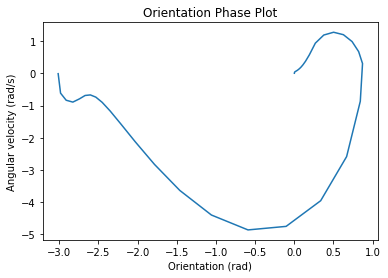

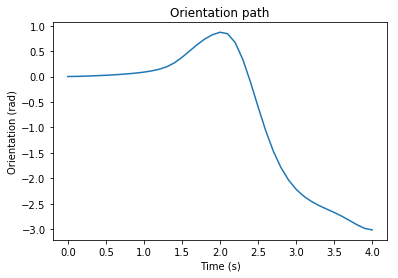

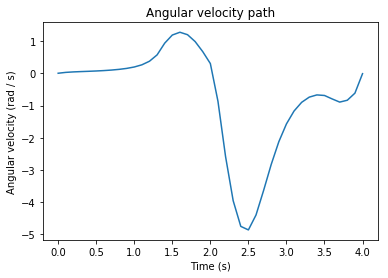

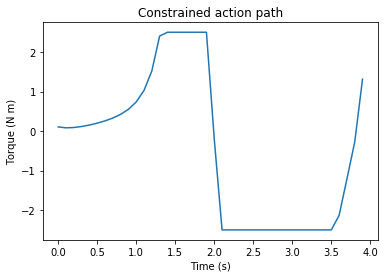

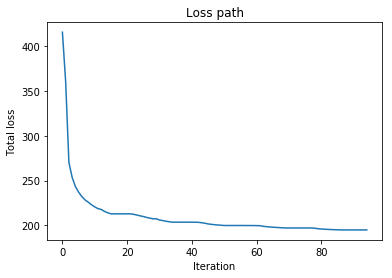

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


SyntaxError: unexpected EOF while parsing (<string>, line 0)

In [15]:
Z = torch.empty(H + 1, Z.shape[-1])
U = torch.empty(H, model.action_size)
Z[0] = env.get_state().encode(ENCODING)
for i in range(H):
    U[i] = controller(Z[i], i, ENCODING, mpc=True, u_min=U_MIN, u_max=U_MAX, on_iteration=on_iteration)
    env.apply(U[i])
    Z[i + 1] = env.get_state().encode(ENCODING)
env.reset()

iteration 1 iLQRState.ACCEPTED 195.0493 [-3.011323   -0.00838166]
iteration 2 iLQRState.ACCEPTED 225.7992 [-2.9031663  0.5429641]
iteration 3 iLQRState.ACCEPTED 195.02138 [-2.9824858  -0.03831127]
iteration 4 iLQRState.ACCEPTED 221.46999 [-2.9249885 -0.5346787]
iteration 5 iLQRState.ACCEPTED 189.15327 [-3.0593662  -0.00888619]
iteration 6 iLQRState.ACCEPTED 187.07722 [-3.0809128  -0.00518867]
iteration 7 iLQRState.ACCEPTED 192.88475 [-3.039746    0.24155939]
iteration 8 iLQRState.ACCEPTED 184.91432 [-3.0925958  -0.00458205]
iteration 9 iLQRState.ACCEPTED 183.38602 [-3.1027565  -0.00329593]
iteration 10 iLQRState.ACCEPTED 182.14209 [-3.1076825e+00 -2.8740317e-03]
iteration 11 iLQRState.ACCEPTED 180.93047 [-3.1133282e+00 -2.3954660e-03]
iteration 12 iLQRState.ACCEPTED 179.65788 [-3.1173394e+00 -2.0551085e-03]
iteration 13 iLQRState.ACCEPTED 178.2481 [-3.1208000e+00 -1.7615184e-03]
iteration 14 iLQRState.ACCEPTED 176.58488 [-3.1226275e+00 -1.6065612e-03]
iteration 15 iLQRState.ACCEPTED 17

iteration 111 iLQRState.ACCEPTED 5.3148907e-09 [-3.1415923e+00 -2.0288013e-07]
iteration 112 iLQRState.ACCEPTED 3.954286e-09 [-3.1415925e+00  3.2511593e-07]
iteration 113 iLQRState.ACCEPTED 2.9622749e-09 [-3.1415925e+00  4.5423803e-07]
iteration 114 iLQRState.ACCEPTED 2.1760214e-09 [-3.1415925e+00  3.2796891e-08]
iteration 115 iLQRState.ACCEPTED 1.62455e-09 [-3.1415925e+00 -3.7182282e-08]
iteration 116 iLQRState.ACCEPTED 1.2180196e-09 [-3.1415925e+00 -8.5518579e-08]
iteration 117 iLQRState.REJECTED 9.144351e-10 [-3.1415925e+00 -1.3229663e-07]
iteration 117 iLQRState.REJECTED 9.144351e-10 [-3.1415925e+00 -1.3229663e-07]
iteration 117 iLQRState.REJECTED 9.144351e-10 [-3.1415925e+00 -1.3229663e-07]
iteration 117 iLQRState.REJECTED 9.144351e-10 [-3.1415925e+00 -1.3229663e-07]
iteration 117 iLQRState.REJECTED 9.144351e-10 [-3.1415925e+00 -1.3229663e-07]
iteration 117 iLQRState.REJECTED 9.144351e-10 [-3.1415925e+00 -1.3229663e-07]
iteration 117 iLQRState.ACCEPTED 9.1442676e-10 [-3.1415925e+0

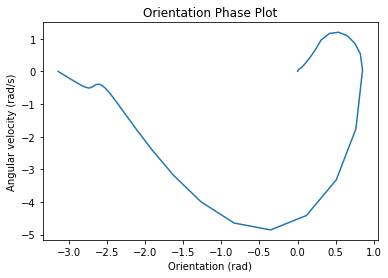

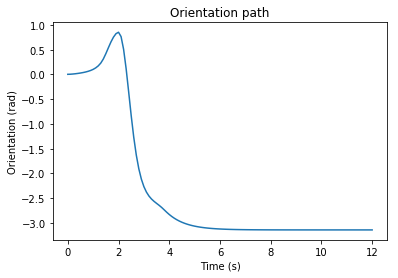

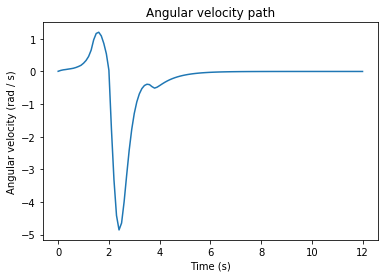

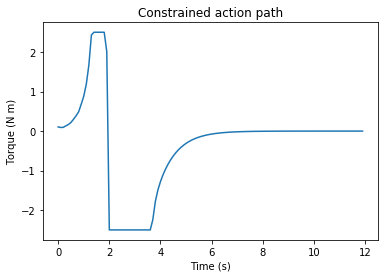

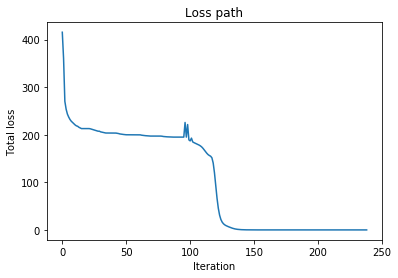

In [16]:
plot(Z, U)

In [ ]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

In [ ]:
for i in range(10):
    env.apply(torch.zeros(model.action_size))

In [19]:
env.close()